# Option & Stock Trading Strategies: A Visual Guide

This notebook explores various trading strategies involving stocks and options. Our goal is to visualize the **Payoff** (value at expiration) and **Profit/Loss (P&L)** profiles to understand what market conditions each strategy aims to capture.

### 1. Strategic Objectives
Traders use these combinations to achieve specific goals:
- **Directional Speculation:** Profiting from a rise or fall in the underlying stock.
- **Income Generation:** Selling "time" (Theta) to collect premiums.
- **Risk Mitigation/Hedging:** Protecting a stock position against adverse moves.
- **Volatility Plays:** Betting on the magnitude of price swings rather than the direction.

### 2. The Payoff Logic
The value of a strategy at expiration ($T$) depends on the relationship between the final stock price ($S_T$) and the strike price ($K$):

- **Long Call Payoff:** $\max(S_T - K, 0)$
- **Long Put Payoff:** $\max(K - S_T, 0)$
- **Net Profit:** $\text{Payoff} - \text{Net Premium Paid}$

### 3. Baseline Assumptions
For consistency across our visualizations, we will use the following default parameters unless otherwise specified:
- **Baseline Stock Price ($S_0$):** $100$
- **Strike Price ($K$):** $105$
- **Volatility ($\sigma$):** $25\%$
- **Time to Maturity ($T$):** $30$ Days

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class StrategySession:
    """
    Maintains the state for trading strategy analysis.
    Provides methods to calculate payoffs and P&L for stock and option legs.
    """
    def __init__(self, S0=100.0, K=105.0, vol=0.25, r=0.0, T_days=30):
        self.S0 = S0
        self.K = K
        self.vol = vol
        self.r = r
        self.T = T_days / 365.0
        
    def payoff_stock(self, S_range, entry_price, position='long'):
        """Calculates P&L for a stock position."""
        if position == 'long':
            return S_range - entry_price
        return entry_price - S_range

    def payoff_call(self, S_range, K, premium, position='long'):
        """Calculates P&L for a call option."""
        payoff = np.maximum(S_range - K, 0)
        if position == 'long':
            return payoff - premium
        return premium - payoff

    def payoff_put(self, S_range, K, premium, position='long'):
        """Calculates P&L for a put option."""
        payoff = np.maximum(K - S_range, 0)
        if position == 'long':
            return payoff - premium
        return premium - payoff

    def plot_strategy(self, S_range, total_pnl, title, labels=None, components=None):
        """Standardized plotting utility for strategies."""
        plt.figure(figsize=(10, 6))
        
        # Plot individual legs if provided
        if components is not None and labels is not None:
            for comp, label in zip(components, labels):
                plt.plot(S_range, comp, '--', alpha=0.5, label=label)
        
        # Plot the combined strategy
        plt.plot(S_range, total_pnl, color='blue', lw=2.5, label='Net Strategy P&L')
        
        plt.axhline(0, color='black', lw=1)
        plt.axvline(self.K, color='red', linestyle='--', alpha=0.3, label=f'Strike (K={self.K})')
        plt.fill_between(S_range, total_pnl, 0, where=(total_pnl > 0), facecolor='green', alpha=0.2)
        plt.fill_between(S_range, total_pnl, 0, where=(total_pnl < 0), facecolor='red', alpha=0.2)
        
        plt.title(title)
        plt.xlabel('Stock Price at Expiration (S_T)')
        plt.ylabel('Profit / Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

# Initialize the session
strat = StrategySession()

print(f"Strategy Session Initialized.")
print(f"Standardized for S0={strat.S0} and K={strat.K}")

Strategy Session Initialized.
Standardized for S0=100.0 and K=105.0


# Strategy 1: Covered Call (Buy-Write)

A **Covered Call** is a popular strategy for investors who already own (or are buying) the underlying stock and want to generate additional income. It involves holding a long position in a stock while simultaneously selling (writing) a call option on that same stock.

### Components
- **Long Stock:** 100 shares of the underlying asset.
- **Short Call:** Selling 1 Out-of-the-Money (OTM) call option (typically).

### Objective
- **Income Generation:** The trader collects the option premium, which acts as a "synthetic dividend" and lowers the cost basis of the stock.
- **Target Market:** Neutral to slightly bullish. The trader expects the stock price to stay relatively flat or rise only modestly up to the strike price.

### Risk/Reward Profile
- **Maximum Profit:** Capped at $(K - S_0) + \text{Premium}$. If the stock goes above the strike ($K$), the stock is "called away," and the trader misses out on further upside.
- **Maximum Loss:** Significant, as the stock price could fall to zero. However, the loss is slightly buffered by the premium received.
- **Breakeven:** $S_0 - \text{Premium}$.

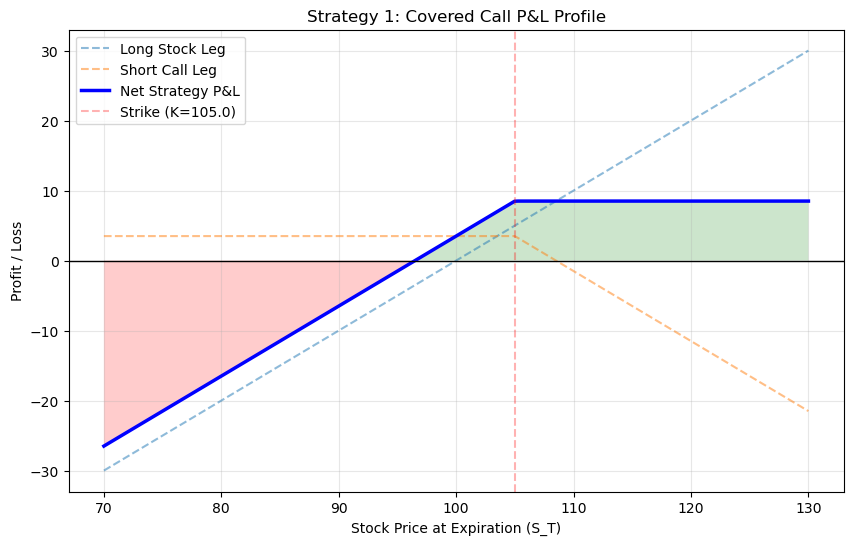

Covered Call Stats:
Max Profit: 8.5
Breakeven: 96.5


In [3]:
# Define range of stock prices at expiration
S_range = np.linspace(70, 130, 200)

# Define specific parameters for this strategy
stock_entry = 100.0
call_strike = 105.0
call_premium = 3.50  # Premium collected from selling the call

# 1. Calculate the Long Stock P&L
stock_pnl = strat.payoff_stock(S_range, entry_price=stock_entry, position='long')

# 2. Calculate the Short Call P&L (position='short')
short_call_pnl = strat.payoff_call(S_range, K=call_strike, premium=call_premium, position='short')

# 3. Combined Strategy P&L
covered_call_pnl = stock_pnl + short_call_pnl

# Use the session's plotting utility
strat.plot_strategy(
    S_range, 
    covered_call_pnl, 
    title='Strategy 1: Covered Call P&L Profile',
    labels=['Long Stock Leg', 'Short Call Leg'],
    components=[stock_pnl, short_call_pnl]
)

print(f"Covered Call Stats:")
print(f"Max Profit: { (call_strike - stock_entry) + call_premium }")
print(f"Breakeven: { stock_entry - call_premium }")

# Strategy 2: Protective Put (Married Put)

The **Protective Put** is an insurance-style strategy. It involves owning the underlying stock and buying a put option to protect against a significant decline in the stock's price.

### Components
- **Long Stock:** 100 shares of the underlying asset.
- **Long Put:** Buying 1 Out-of-the-Money (OTM) or At-the-Money (ATM) put option.

### Objective
- **Hedging/Insurance:** The trader wants to participate in the stock's upside while having a "floor" on potential losses.
- **Target Market:** Bullish on the stock long-term, but concerned about short-term downside or "black swan" events.

### Risk/Reward Profile
- **Maximum Profit:** Unlimited (as the stock can rise indefinitely), minus the premium paid for the put.
- **Maximum Loss:** Limited to $(S_0 - K) + \text{Premium}$. This is the "cost of the insurance."
- **Breakeven:** $S_0 + \text{Premium}$.

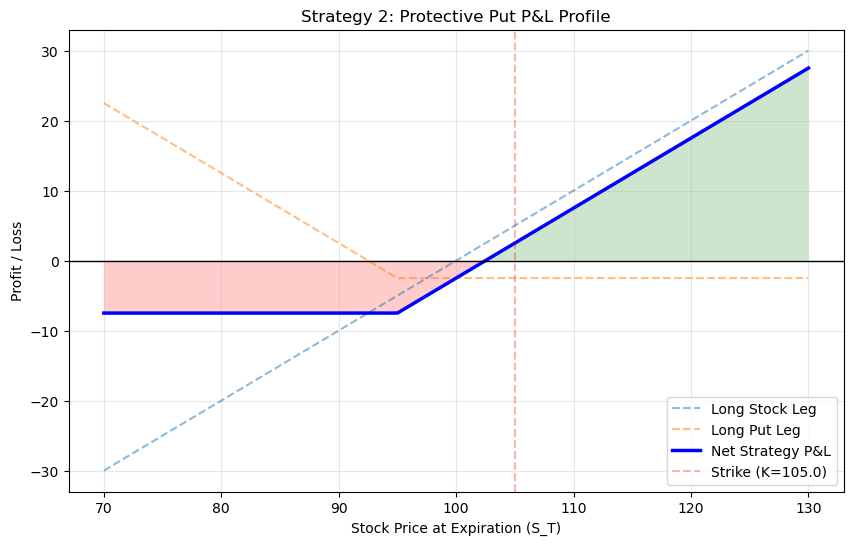

Protective Put Stats:
Max Loss: -7.5
Breakeven: 102.5


In [4]:
# Define range of stock prices at expiration
S_range = np.linspace(70, 130, 200)

# Define specific parameters for this strategy
stock_entry = 100.0
put_strike = 95.0
put_premium = 2.50  # The "insurance premium" paid for the put

# 1. Calculate the Long Stock P&L
stock_pnl = strat.payoff_stock(S_range, entry_price=stock_entry, position='long')

# 2. Calculate the Long Put P&L
long_put_pnl = strat.payoff_put(S_range, K=put_strike, premium=put_premium, position='long')

# 3. Combined Strategy P&L
protective_put_pnl = stock_pnl + long_put_pnl

# Use the session's plotting utility
strat.plot_strategy(
    S_range, 
    protective_put_pnl, 
    title='Strategy 2: Protective Put P&L Profile',
    labels=['Long Stock Leg', 'Long Put Leg'],
    components=[stock_pnl, long_put_pnl]
)

print(f"Protective Put Stats:")
print(f"Max Loss: { (put_strike - stock_entry) - put_premium }")
print(f"Breakeven: { stock_entry + put_premium }")

# Strategy 3: Long Straddle

A **Long Straddle** is a volatility-focused strategy. It involves buying both a call and a put option on the same underlying stock, with the same strike price and expiration date.

### Components
- **Long Call:** 1 At-the-Money (ATM) call option.
- **Long Put:** 1 At-the-Money (ATM) put option.

### Objective
- **Volatility Play:** The trader expects a significant price move in the underlying stock but is unsure of the direction. This is common before major events like earnings announcements or regulatory rulings.
- **Target Market:** High volatility. The trader is betting that the stock will move further than the market currently expects (the "implied move").

### Risk/Reward Profile
- **Maximum Profit:** Theoretically unlimited to the upside (as the stock rises) and substantial to the downside (as the stock falls toward zero).
- **Maximum Loss:** Limited to the total premium paid for both options. This occurs if the stock price is exactly at the strike price at expiration.
- **Breakevens:** 
  - Upper Breakeven: $K + \text{Total Premium}$
  - Lower Breakeven: $K - \text{Total Premium}$

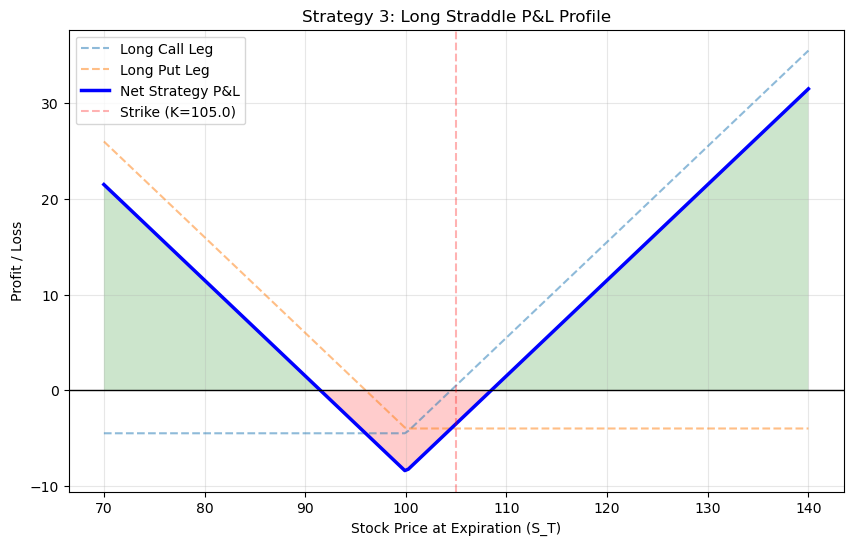

Long Straddle Stats:
Max Loss (at K=100.0): -8.5
Upper Breakeven: 108.5
Lower Breakeven: 91.5


In [6]:
# Define range of stock prices at expiration
S_range = np.linspace(70, 140, 200)

# Define specific parameters for this strategy
straddle_strike = 100.0
call_prem = 4.50
put_prem = 4.00
total_premium = call_prem + put_prem

# 1. Calculate the Long Call P&L
long_call_pnl = strat.payoff_call(S_range, K=straddle_strike, premium=call_prem, position='long')

# 2. Calculate the Long Put P&L
long_put_pnl = strat.payoff_put(S_range, K=straddle_strike, premium=put_prem, position='long')

# 3. Combined Strategy P&L
straddle_pnl = long_call_pnl + long_put_pnl

# Use the session's plotting utility
strat.plot_strategy(
    S_range, 
    straddle_pnl, 
    title='Strategy 3: Long Straddle P&L Profile',
    labels=['Long Call Leg', 'Long Put Leg'],
    components=[long_call_pnl, long_put_pnl]
)

print(f"Long Straddle Stats:")
print(f"Max Loss (at K={straddle_strike}): { -total_premium }")
print(f"Upper Breakeven: { straddle_strike + total_premium }")
print(f"Lower Breakeven: { straddle_strike - total_premium }")

# Strategy 4: Bull Call Spread (Debit Call Spread)

A **Bull Call Spread** is a vertical spread strategy used when a trader is moderately bullish on a stock. It involves buying a call option at a lower strike price and selling another call option at a higher strike price, both with the same expiration.

### Components
- **Long Call:** Buying 1 At-the-Money (ATM) or slightly Out-of-the-Money (OTM) call.
- **Short Call:** Selling 1 further Out-of-the-Money (OTM) call.

### Objective
- **Cost Reduction:** Selling the higher-strike call generates premium that offsets the cost of the lower-strike call.
- **Directional Bet:** The trader expects the stock to rise, but is willing to cap their upside in exchange for a lower entry cost and reduced "Theta" (time decay) risk.

### Risk/Reward Profile
- **Maximum Profit:** Capped at $(\text{Strike}_2 - \text{Strike}_1) - \text{Net Premium Paid}$.
- **Maximum Loss:** Limited to the **Net Premium Paid** (the debit).
- **Breakeven:** $\text{Lower Strike} + \text{Net Premium Paid}$.

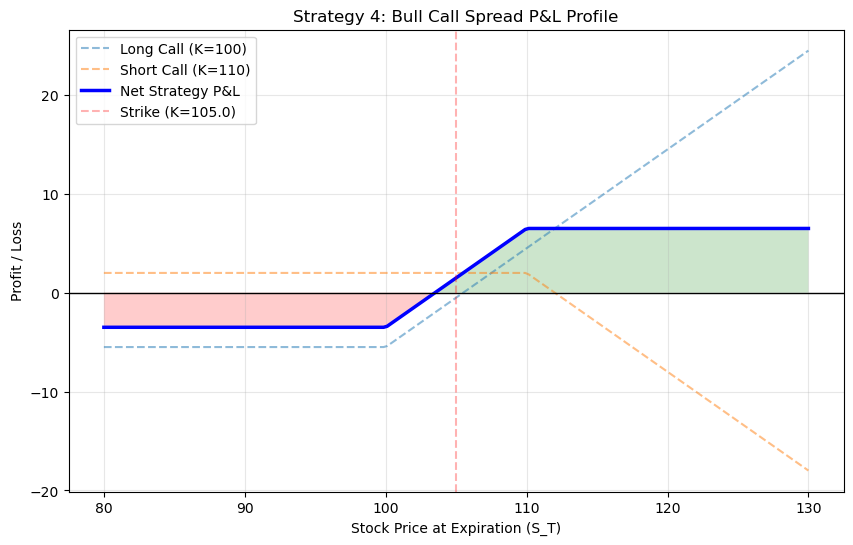

Bull Call Spread Stats:
Net Debit (Max Loss): 3.5
Max Profit: 6.5
Breakeven: 103.5


In [7]:
# Define range of stock prices at expiration
S_range = np.linspace(80, 130, 200)

# Define specific parameters for this spread
lower_strike = 100.0
upper_strike = 110.0
long_call_prem = 5.50
short_call_prem = 2.00
net_premium = long_call_prem - short_call_prem

# 1. Calculate the Long Call P&L
long_call_pnl = strat.payoff_call(S_range, K=lower_strike, premium=long_call_prem, position='long')

# 2. Calculate the Short Call P&L
short_call_pnl = strat.payoff_call(S_range, K=upper_strike, premium=short_call_prem, position='short')

# 3. Combined Strategy P&L
bull_call_pnl = long_call_pnl + short_call_pnl

# Use the session's plotting utility
strat.plot_strategy(
    S_range, 
    bull_call_pnl, 
    title='Strategy 4: Bull Call Spread P&L Profile',
    labels=['Long Call (K=100)', 'Short Call (K=110)'],
    components=[long_call_pnl, short_call_pnl]
)

print(f"Bull Call Spread Stats:")
print(f"Net Debit (Max Loss): { net_premium }")
print(f"Max Profit: { (upper_strike - lower_strike) - net_premium }")
print(f"Breakeven: { lower_strike + net_premium }")

# Strategy 5: Bear Put Spread (Debit Put Spread)

A **Bear Put Spread** is a vertical spread strategy used when a trader is moderately bearish on a stock. It is the mirror image of the Bull Call Spread. It involves buying a put option at a higher strike price and selling another put option at a lower strike price, both with the same expiration.

### Components
- **Long Put:** Buying 1 At-the-Money (ATM) or slightly Out-of-the-Money (OTM) put.
- **Short Put:** Selling 1 further Out-of-the-Money (OTM) put.

### Objective
- **Cost Reduction:** Selling the lower-strike put generates a premium that offsets the cost of the higher-strike put.
- **Directional Bet:** The trader expects the stock to fall, but limits their potential profit in exchange for a lower entry cost and reduced "Theta" risk compared to a single long put.

### Risk/Reward Profile
- **Maximum Profit:** Capped at $(\text{Upper Strike} - \text{Lower Strike}) - \text{Net Premium Paid}$.
- **Maximum Loss:** Limited to the **Net Premium Paid** (the debit).
- **Breakeven:** $\text{Upper Strike} - \text{Net Premium Paid}$.

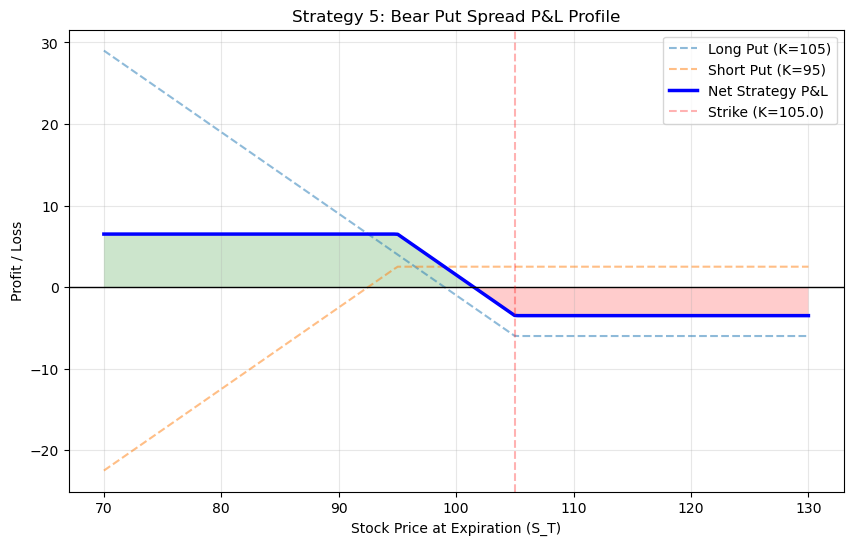

Bear Put Spread Stats:
Net Debit (Max Loss): 3.5
Max Profit: 6.5
Breakeven: 101.5


In [8]:
# Define range of stock prices at expiration
S_range = np.linspace(70, 130, 200)

# Define specific parameters for this bearish spread
upper_strike = 105.0
lower_strike = 95.0
long_put_prem = 6.00
short_put_prem = 2.50
net_premium = long_put_prem - short_put_prem

# 1. Calculate the Long Put P&L (Higher Strike)
long_put_pnl = strat.payoff_put(S_range, K=upper_strike, premium=long_put_prem, position='long')

# 2. Calculate the Short Put P&L (Lower Strike)
short_put_pnl = strat.payoff_put(S_range, K=lower_strike, premium=short_put_prem, position='short')

# 3. Combined Strategy P&L
bear_put_pnl = long_put_pnl + short_put_pnl

# Use the session's plotting utility
strat.plot_strategy(
    S_range, 
    bear_put_pnl, 
    title='Strategy 5: Bear Put Spread P&L Profile',
    labels=['Long Put (K=105)', 'Short Put (K=95)'],
    components=[long_put_pnl, short_put_pnl]
)

print(f"Bear Put Spread Stats:")
print(f"Net Debit (Max Loss): { net_premium }")
print(f"Max Profit: { (upper_strike - lower_strike) - net_premium }")
print(f"Breakeven: { upper_strike - net_premium }")

# Strategy 6: Long Strangle

A **Long Strangle** is a volatility-focused strategy similar to the Long Straddle. The key difference is that the trader buys **Out-of-the-Money (OTM)** call and put options instead of At-the-Money options.

### Components
- **Long OTM Call:** 1 call option with a strike price higher than the current stock price.
- **Long OTM Put:** 1 put option with a strike price lower than the current stock price.

### Objective
- **Volatility Play (Cheaper):** Like the straddle, the trader expects a large move but is unsure of the direction. By using OTM options, the "entry ticket" (total premium paid) is significantly cheaper.
- **Target Market:** Very high volatility. The trader is betting on an "explosive" move that will push the stock past the OTM strikes.

### Risk/Reward Profile
- **Maximum Profit:** Theoretically unlimited to the upside and substantial to the downside.
- **Maximum Loss:** Limited to the total premium paid. This occurs if the stock stays between the two strike prices at expiration.
- **Breakevens:** 
  - Upper Breakeven: $\text{Call Strike} + \text{Total Premium}$
  - Lower Breakeven: $\text{Put Strike} - \text{Total Premium}$

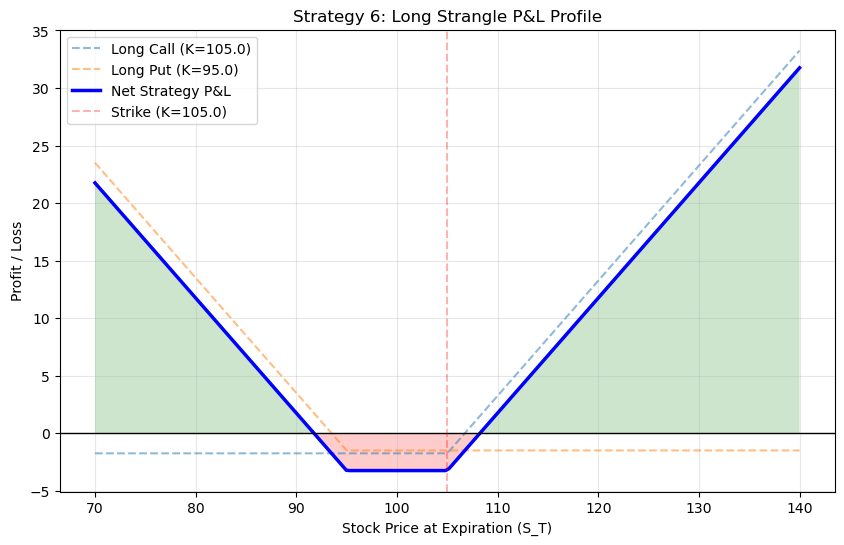

Long Strangle Stats:
Net Debit (Max Loss): 3.25
Upper Breakeven: 108.25
Lower Breakeven: 91.75


In [11]:
# Define range of stock prices at expiration
S_range = np.linspace(70, 140, 200)

# Define specific parameters for the strangle
put_strike = 95.0
call_strike = 105.0
put_prem = 1.50
call_prem = 1.75
total_premium = put_prem + call_prem

# 1. Calculate the Long Call P&L (OTM)
long_call_pnl = strat.payoff_call(S_range, K=call_strike, premium=call_prem, position='long')

# 2. Calculate the Long Put P&L (OTM)
long_put_pnl = strat.payoff_put(S_range, K=put_strike, premium=put_prem, position='long')

# 3. Combined Strategy P&L
strangle_pnl = long_call_pnl + long_put_pnl

# Use the session's plotting utility
# Note: We'll set the vertical line to the center of the strikes for visual reference
strat.plot_strategy(
    S_range, 
    strangle_pnl, 
    title='Strategy 6: Long Strangle P&L Profile',
    labels=[f'Long Call (K={call_strike})', f'Long Put (K={put_strike})'],
    components=[long_call_pnl, long_put_pnl]
)

print(f"Long Strangle Stats:")
print(f"Net Debit (Max Loss): { total_premium }")
print(f"Upper Breakeven: { call_strike + total_premium }")
print(f"Lower Breakeven: { put_strike - total_premium }")

# Neutral-Market Strategies

Market-neutral strategies are designed to profit when the underlying stock price stays within a specific range. Unlike directional bets, these strategies typically "sell volatility" (Short Vega) and "collect time decay" (Positive Theta).

### Key Characteristics
- **Range-Bound Profitability:** The ideal scenario is for the stock to remain relatively flat until expiration.
- **Profit from Stability:** These trades often involve selling options to collect premium, betting that the market's expectation of a move (Implied Volatility) is higher than the actual move.
- **Risk Profiles:** They can be **defined-risk** (like Iron Condors or Butterfly Spreads) or **undefined-risk** (like Short Straddles).

### Strategies We Will Explore:
1.  **Iron Condor:** A multi-leg spread that profits from low volatility with limited risk.
2.  **Butterfly Spread:** A highly concentrated neutral bet with a sharp profit peak.

# Strategy 7: Iron Condor

The **Iron Condor** is one of the most popular neutral strategies. It is essentially a combination of a **Bull Put Spread** and a **Bear Call Spread**. By selling both a put and a call at OTM strikes, the trader creates a wide "profit zone."

### Components
- **Sell 1 OTM Put** (Lower Strike $K_1$)
- **Buy 1 further OTM Put** (Wing $K_2$) — *For Protection*
- **Sell 1 OTM Call** (Upper Strike $K_3$)
- **Buy 1 further OTM Call** (Wing $K_4$) — *For Protection*

### Objective
- **Income Generation:** Collect premium from both sides of the market.
- **Low Volatility Bet:** Profit if the stock price stays between the two short strikes ($K_1$ and $K_3$).

### Risk/Reward Profile
- **Maximum Profit:** Limited to the **Net Premium Received**.
- **Maximum Loss:** Limited to $(\text{Wing Width}) - \text{Net Premium Received}$.
- **Breakevens:** 
  - Upper: $\text{Short Call Strike} + \text{Net Premium}$
  - Lower: $\text{Short Put Strike} - \text{Net Premium}$

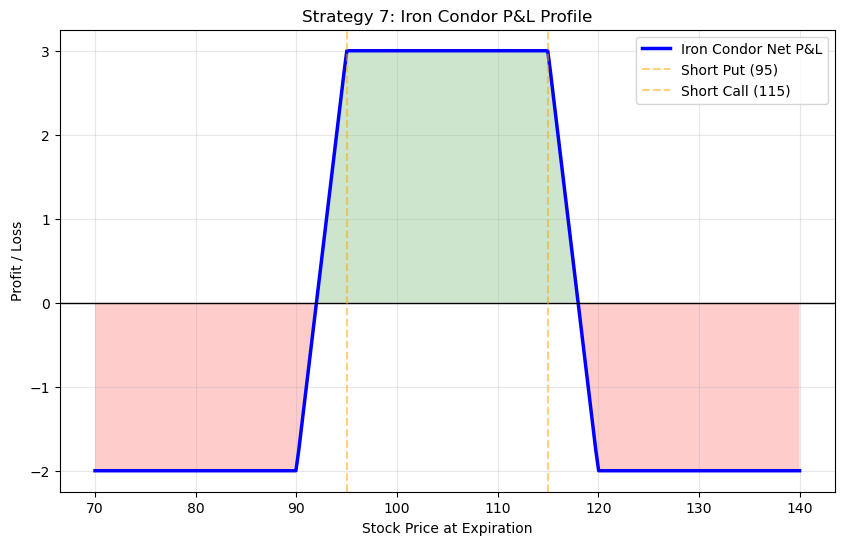

Iron Condor Stats:
Max Profit (Net Credit): 3.0
Max Loss: 2.0


In [9]:
# Define range of stock prices
S_range = np.linspace(70, 140, 250)

# Define Iron Condor Strikes (centered around 105)
put_wing = 90.0
put_short = 95.0
call_short = 115.0
call_wing = 120.0

# Estimated premiums
p_wing_prem = 1.00
p_short_prem = 2.50
c_short_prem = 2.50
c_wing_prem = 1.00

# Calculate Net Premium Received (Income)
net_credit = (p_short_prem - p_wing_prem) + (c_short_prem - c_wing_prem)

# 1. Bull Put Spread Legs
leg1 = strat.payoff_put(S_range, K=put_wing, premium=p_wing_prem, position='long')
leg2 = strat.payoff_put(S_range, K=put_short, premium=p_short_prem, position='short')

# 2. Bear Call Spread Legs
leg3 = strat.payoff_call(S_range, K=call_short, premium=c_short_prem, position='short')
leg4 = strat.payoff_call(S_range, K=call_wing, premium=c_wing_prem, position='long')

# 3. Combined Iron Condor P&L
iron_condor_pnl = leg1 + leg2 + leg3 + leg4

# Use the session's plotting utility
# We'll override the strike marker for clarity since we have 4 strikes
plt.figure(figsize=(10, 6))
plt.plot(S_range, iron_condor_pnl, color='blue', lw=2.5, label='Iron Condor Net P&L')
plt.axhline(0, color='black', lw=1)
plt.fill_between(S_range, iron_condor_pnl, 0, where=(iron_condor_pnl > 0), facecolor='green', alpha=0.2)
plt.fill_between(S_range, iron_condor_pnl, 0, where=(iron_condor_pnl < 0), facecolor='red', alpha=0.2)

# Mark the short strikes (The Profit Zone)
plt.axvline(put_short, color='orange', linestyle='--', alpha=0.5, label='Short Put (95)')
plt.axvline(call_short, color='orange', linestyle='--', alpha=0.5, label='Short Call (115)')

plt.title('Strategy 7: Iron Condor P&L Profile')
plt.xlabel('Stock Price at Expiration')
plt.ylabel('Profit / Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Iron Condor Stats:")
print(f"Max Profit (Net Credit): {net_credit}")
print(f"Max Loss: {(put_short - put_wing) - net_credit}")

# Strategy 8: Butterfly Spread

The **Butterfly Spread** is a neutral strategy that combines a Bull Spread and a Bear Spread. It uses three different strike prices but all options are of the same type (all calls or all puts). It is designed to have a very high potential return if the stock finishes exactly at the middle strike, with very low risk.

### Components (Long Call Butterfly)
- **Buy 1 ITM Call:** Lower Strike ($K_1$)
- **Sell 2 ATM Calls:** Middle Strike ($K_2$) — *This is the "Body" of the butterfly*
- **Buy 1 OTM Call:** Upper Strike ($K_3$) — *The "Wings"*
*Note: The distance between strikes is typically equal ($K_2 - K_1 = K_3 - K_2$).*

### Objective
- **Minimal Volatility:** Profit if the stock remains extremely stable and "pins" the middle strike ($K_2$) at expiration.
- **High ROI:** Because the net cost (debit) is very low, the percentage return can be very high if the stock finishes near the peak.

### Risk/Reward Profile
- **Maximum Profit:** $(\text{Middle Strike} - \text{Lower Strike}) - \text{Net Premium Paid}$.
- **Maximum Loss:** Limited to the **Net Premium Paid**.
- **Breakevens:** 
  - Upper: $K_3 - \text{Net Premium}$
  - Lower: $K_1 + \text{Net Premium}$

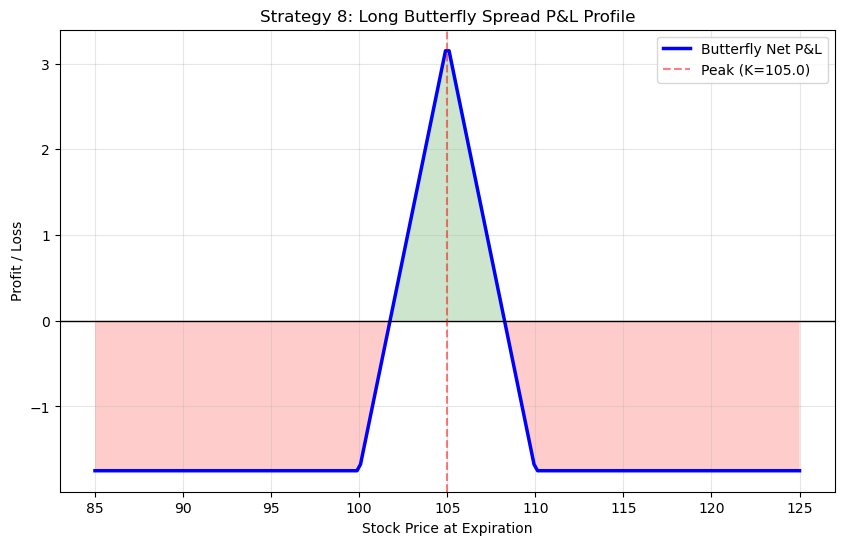

Butterfly Spread Stats:
Net Debit (Max Loss): 1.75
Max Profit at 105.0: 3.25


In [10]:
# Define range of stock prices
S_range = np.linspace(85, 125, 200)

# Define Butterfly strikes (centered around 105)
low_strike = 100.0
mid_strike = 105.0
high_strike = 110.0

# Estimated premiums
c_low_prem = 7.50
c_mid_prem = 3.50  # We sell 2 of these
c_high_prem = 1.25

# Calculate Net Premium Paid (Debit)
# (Buy 1 Low + Buy 1 High) - (Sell 2 Mid)
net_debit = (c_low_prem + c_high_prem) - (2 * c_mid_prem)

# 1. Lower Strike Leg
leg1 = strat.payoff_call(S_range, K=low_strike, premium=c_low_prem, position='long')

# 2. Middle Strike Leg (Selling 2 calls)
leg2 = 2 * strat.payoff_call(S_range, K=mid_strike, premium=c_mid_prem, position='short')

# 3. Upper Strike Leg
leg3 = strat.payoff_call(S_range, K=high_strike, premium=c_high_prem, position='long')

# 4. Combined Butterfly P&L
butterfly_pnl = leg1 + leg2 + leg3

# Use the session's plotting utility
# We'll override the strike marker to show the peak
plt.figure(figsize=(10, 6))
plt.plot(S_range, butterfly_pnl, color='blue', lw=2.5, label='Butterfly Net P&L')
plt.axhline(0, color='black', lw=1)
plt.fill_between(S_range, butterfly_pnl, 0, where=(butterfly_pnl > 0), facecolor='green', alpha=0.2)
plt.fill_between(S_range, butterfly_pnl, 0, where=(butterfly_pnl < 0), facecolor='red', alpha=0.2)

plt.axvline(mid_strike, color='red', linestyle='--', alpha=0.5, label=f'Peak (K={mid_strike})')

plt.title('Strategy 8: Long Butterfly Spread P&L Profile')
plt.xlabel('Stock Price at Expiration')
plt.ylabel('Profit / Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Butterfly Spread Stats:")
print(f"Net Debit (Max Loss): {net_debit}")
print(f"Max Profit at {mid_strike}: {(mid_strike - low_strike) - net_debit}")

# Strategy 9: Calendar Spread (Time Spread)

A **Calendar Spread** involves selling a short-term option and buying a longer-term option with the same strike price. Unlike vertical spreads, which play on price movement, the Calendar Spread plays on the passage of time (**Theta**) and changes in volatility (**Vega**).

### Components (Long Call Calendar)
- **Sell 1 Short-Term Call:** Near-term expiration (e.g., 30 days).
- **Buy 1 Long-Term Call:** Further-out expiration (e.g., 60 or 90 days).
*Note: Both options have the same strike price, usually At-the-Money (ATM).*

### Objective
- **Theta Play:** Short-term options decay faster than long-term options. The trader profits as the near-term option loses value more quickly than the long-term one.
- **Volatility Play:** Because the long-term option has a higher Vega, the trader profits if implied volatility increases.
- **Target Market:** Neutral. The goal is for the stock to be exactly at the strike price when the near-term option expires.

### Risk/Reward Profile
- **Maximum Profit:** Occurs if the stock is at the strike price at the first expiration. It is difficult to calculate precisely because it depends on the remaining value of the long-term option.
- **Maximum Loss:** Limited to the **Net Premium Paid** (the debit).
- **Breakevens:** Two breakevens (upper and lower), but they shift as volatility changes.

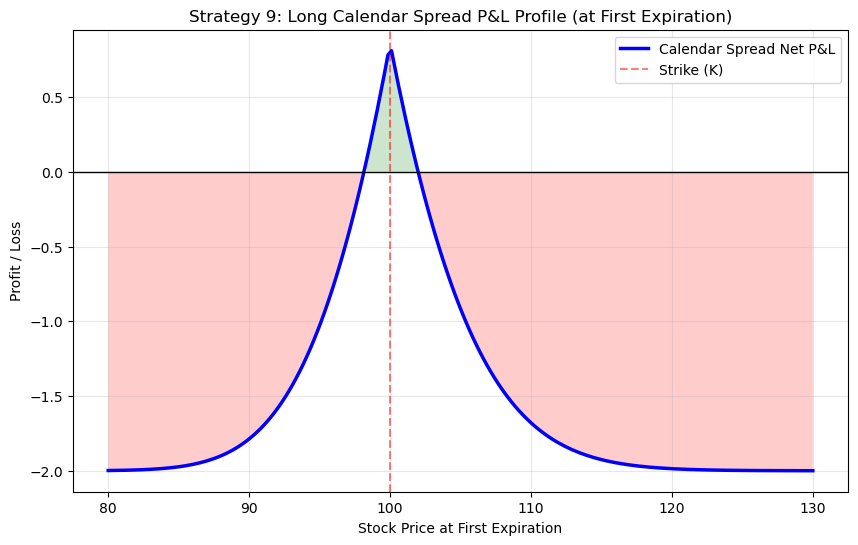

Calendar Spread Stats:
Net Debit (Max Loss): 2.0
Max Profit occurs near: 100.0


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm  # Added missing import

# Define range of stock prices
S_range = np.linspace(80, 130, 200)

# Define Calendar strikes (ATM at 100)
strike = 100.0

# Estimated premiums
short_call_prem = 3.50  # 30-day option
long_call_prem = 5.50   # 60-day option
net_debit = long_call_prem - short_call_prem

def long_option_remaining_value(S, K, T_remaining, vol):
    # Simplified Black-Scholes-like estimation for remaining value
    # At the first expiration, the 60-day option still has 30 days left.
    # T_remaining should be in years for standard BSM
    d1 = (np.log(S/K) + (0.5 * vol**2) * T_remaining) / (vol * np.sqrt(T_remaining))
    return S * norm.cdf(d1) - K * norm.cdf(d1 - vol * np.sqrt(T_remaining))

# 1. Short Call P&L at expiration (30 days)
short_pnl = strat.payoff_call(S_range, K=strike, premium=short_call_prem, position='short')

# 2. Long Call Value at 30 days (still has 30 days left)
# We use T_remaining = 30/365
long_val_at_30d = long_option_remaining_value(S_range, strike, T_remaining=30/365, vol=0.25)
long_pnl = long_val_at_30d - long_call_prem

# 3. Combined Calendar P&L
calendar_pnl = short_pnl + long_pnl

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(S_range, calendar_pnl, color='blue', lw=2.5, label='Calendar Spread Net P&L')
plt.axhline(0, color='black', lw=1)
plt.fill_between(S_range, calendar_pnl, 0, where=(calendar_pnl > 0), facecolor='green', alpha=0.2)
plt.fill_between(S_range, calendar_pnl, 0, where=(calendar_pnl < 0), facecolor='red', alpha=0.2)
plt.axvline(strike, color='red', linestyle='--', alpha=0.5, label='Strike (K)')

plt.title('Strategy 9: Long Calendar Spread P&L Profile (at First Expiration)')
plt.xlabel('Stock Price at First Expiration')
plt.ylabel('Profit / Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Calendar Spread Stats:")
print(f"Net Debit (Max Loss): {net_debit}")
print(f"Max Profit occurs near: {strike}")

# Conclusion: Choosing the Right Strategy

The best strategy depends on your **Market View** (Direction), your **Volatility Outlook**, and your **Risk Tolerance**.

### 1. Strategy Comparison Matrix

| Strategy | Market View | Volatility View | Risk | Reward |
| :--- | :--- | :--- | :--- | :--- |
| **Covered Call** | Neutral / Slightly Bullish | Neutral / Falling | Significant (Stock) | Capped |
| **Protective Put** | Bullish | Any | Limited | Unlimited |
| **Long Straddle** | Any (Big Move) | Rising | Limited (Premium) | Significant |
| **Bull Call Spread** | Moderately Bullish | Neutral | Limited (Debit) | Capped |
| **Bear Put Spread** | Moderately Bearish | Neutral | Limited (Debit) | Capped |
| **Iron Condor** | Neutral (Range-bound) | Falling | Limited | Capped (Credit) |
| **Butterfly Spread** | Neutral (Pin) | Falling | Very Limited | High ROI (if pinned) |
| **Calendar Spread** | Neutral | Rising | Limited | Capped |

### 2. Key Takeaways

- **Directional vs. Non-Directional:** Spreads and Puts/Calls are directional. Straddles and Iron Condors are non-directional (market-neutral).
- **Buying vs. Selling Volatility:** If you expect the market to "wake up" and move violently, you **buy** volatility (Straddles, Strangles). If you expect the market to "calm down" and stay quiet, you **sell** volatility (Iron Condors, Butterflies).
- **The Role of Time (Theta):** Strategies where you **sell** options (like Covered Calls or Iron Condors) benefit from the passage of time. Strategies where you **buy** options (like Straddles or single Puts/Calls) are "decaying assets" and require a move to happen quickly to be profitable.

